In [14]:
# %matplotlib notebook 
# from IPython.display import HTML, clear_output
# import matplotlib.animation


from matplotlib import pyplot as plt
import numpy as np
from typing import List, Callable

newparams = {'figure.figsize': (12, 6), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

In [5]:
class Particle:
    x: float
    y: float
    vx: float = 0.0
    vy: float = 0.0

    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"{self.x=}, {self.y=}, {self.vx=}, {self.vy=}"
    
    
    def __str__(self):
        return self.__repr__()

class Microstate:
    particles: List[Particle]

    def get_points_lists(self):
        return [p.x for p in self.particles], [p.y for p in self.particles]


    def plot_particles(self):
        x_values = [p.x for p in self.particles]
        y_values = [p.y for p in self.particles]

        plt.plot(x_values, y_values, "o")

    def __init__(self, particle_list: List[Particle]):
        self.particles = particle_list

In [49]:
# def hamiltonian_function(particle_list: List[Particle], potential_function: Callable[[Particle], float], potential_function_interaction: Callable[[Particle, Particle], float]) -> float:
#     kinetic_energy: float = sum([(p.vx**2 + p.vy**2)/(2*p.mass) for p in particle_list])
#     interaction_potential: float = 0.0
#     potential_energy = sum([potential_function(p) for p in particle_list])
    
#     for i in range(len(particle_list)):
#         for j in range(i + 1, len(particle_list)):
#             interaction_potential += potential_function_interaction(particle_list[i], particle_list[j])
    
#     return kinetic_energy + interaction_potential + potential_energy

#  def animate_states(states: List[Microstate], L, fps):
#     fig, ax = plt.subplots()
#     rect = plt.Rectangle((0,0), L, L, linewidth=1, edgecolor="k", facecolor="none")
#     ax.add_patch(rect)
#     x_values, y_values = states[0].get_points_lists()
#     graph, = ax.plot(x_values, y_values, "o")

#     def animate(i: int):
#         state = states[i]
#         x_values, y_values = state.get_points_lists()
#         graph.set_data(x_values, y_values)

#     ani = matplotlib.animation.FuncAnimation(fig, animate, len(states), interval=1000/fps)
#     return HTML(ani.to_jshtml())

def wall_potential_function_x(particle: Particle, K: float, L: float):
    if particle.x > L:
        return K/2 * (particle.x - L)**2

    if particle.x < 0:
        return K/2 * particle.x ** 2

    return 0 


def wall_potential_function_y(particle: Particle, K: float, L: float):
    if particle.y > L:
        return K/2 * (particle.y - L)**2

    if particle.y < 0:
        return K/2 * particle.y ** 2

    return 0 

def wall_potential_function_w(particle: Particle, K: float, L: float):
    return wall_potential_function_x(particle, K, L) + wall_potential_function_y(particle, K, L)

def wall_potential_function_numpy(particle, K, L):
    potential = 0
    if particle[0] > L:
        potential += K/2 * (particle[0]-L)**2
    elif particle[0] < 0:
        potential += K/2 * particle[0]**2
    
    if particle[1] > L:
        potential += K/2 * (particle[1]-L)**2
    elif particle[1] < 0:
        potential += K/2 * particle[1]**2
    
    return potential

def calculate_pressure_function_numpy(state: Microstate, K: float, L: float):
    total_pressure = 0
    for p in state.particles:
        if p.y > L:
            total_pressure += K*(p.y-L)
        elif p.y < 0:
            total_pressure += K*p.y

        if p.x > L:
            total_pressure += K*(p.x-L)
        elif p.x < 0:
            total_pressure += K*p.x

    return total_pressure/(4*L)

def calculate_pressure_function(state: Microstate, K: float, L: float):
    total_pressure = 0
    for p in state.particles:
        if p.y > L:
            total_pressure += K*(p.y-L)
        elif p.y < 0:
            total_pressure += K*p.y

        if p.x > L:
            total_pressure += K*(p.x-L)
        elif p.x < 0:
            total_pressure += K*p.x

    return total_pressure/(4*L)

def hardcore_repulsion_potential_function(p1: Particle, p2: Particle, a: float, U: float) -> float:
    if abs((p1.x**2 + p1.y**2) - (p2.x**2 + p2.y**2)) < a:
        return U
    return 0.0 

def lennard_jones_potential_function(p1: Particle, p2: Particle, a: float, epsilon: float) -> float:
    rij = abs((p1.x**2 + p1.y**2) - (p2.x**2 + p2.y**2))
    return epsilon*((a/rij)**12 - 2*(a/rij)**6)

In [7]:
def delta_energy_function(particle: Particle, old_particle: Particle, other_particles: List[Particle], wall_potential_func: Callable[[Particle], float], interaction_potential_func: Callable[[Particle, Particle], float]):
    wall_potential = wall_potential_func(particle)  
    old_wall_potential = wall_potential_func(old_particle)
    interaction_potential = sum([interaction_potential_func(particle, p) for p in other_particles])
    old_interaction_potential = sum([interaction_potential_func(old_particle, p) for p in other_particles])

    return wall_potential + interaction_potential - old_wall_potential - old_interaction_potential

def MonteCarlo_metropolis2D(particles_list: List[Particle], energy_change_func: Callable[[Particle, Particle, List[Particle], Callable[[Particle], float], Callable[[Particle, Particle], float]], float], wall_potential_func: Callable[[Particle], float], interaction_potential_func: Callable[[Particle, Particle], float], N: int, beta: float, b: float = 0.5):
    out: List[Microstate] = [Microstate([Particle(p.x, p.y) for p in particle_list])]

    
    for i in range(N):
        index = np.random.randint(0, len(particles_list))

        p_current = particles_list[index]
        p_next = Particle(p_current.x, p_current.y)
        dx = (np.random.random() - 0.5)*b
        dy = (np.random.random() - 0.5)*b
        p_next.x += dx
        p_next.y += dy
        dE = energy_change_func(p_next, p_current, particles_list[0:index] + particles_list[index+1:-1], wall_potential_func, interaction_potential_func)
        if dE <= 0:
            particles_list[index].x = p_next.x
            particles_list[index].y = p_next.y
        else:
            probability = np.random.random()  
            if probability < np.exp(-beta*dE):
                particles_list[index] = p_next
        out.append(Microstate([Particle(p.x, p.y) for p in particle_list]))
    return out



## Taske a)

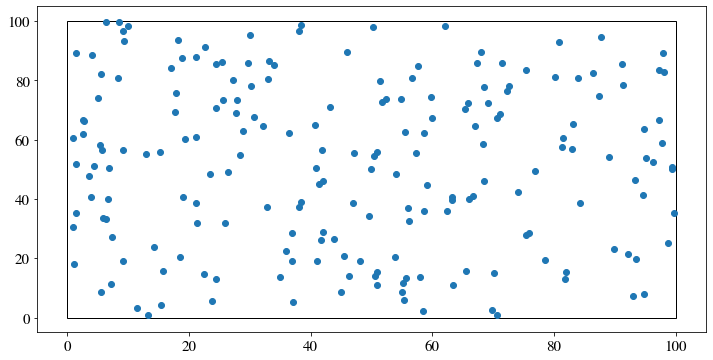

In [20]:
N = 200
L = 100
K = 100000
beta =(1e-23 * 300)**(-1)
steps = 1000
a = 1
b= 0.5
particle_list: List[Particle] = []
for i in range(N):
    particle_list.append(Particle(np.random.random()*L, np.random.random()*L))

# energy_change_function = lambda 

states = MonteCarlo_metropolis2D(particle_list, delta_energy_function, lambda p : wall_potential_function_w(p, K, L), lambda p1, p2 : 0, steps, beta, b)
x_values, y_values = states[-1].get_points_lists()

# lambda p1, p2 : hardcore_repulsion_potential_function(p1, p2, a, 1000/beta)

fig, ax = plt.subplots()
rect = plt.Rectangle((0,0), L, L, linewidth=1, edgecolor="k", facecolor="none")
ax.plot(x_values, y_values, "o")
ax.add_patch(rect)
plt.show()

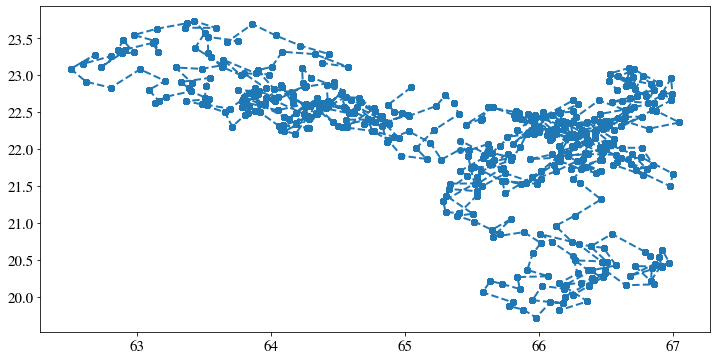

In [15]:
j = np.random.randint(0, len(states[-1].particles))
p1_x_values = [s.particles[j].x for s in states]
p1_y_values = [s.particles[j].y for s in states]

x_values, y_values = states[0].get_points_lists()

# plt.plot(p1_y_values)
# fig, ax = plt.subplots()
plt.plot(p1_x_values, p1_y_values, "--o")
plt.show()
# states[-1].plot_particles()

In [78]:
lengths = np.linspace(0.1, 1, 100)
N = 20
K = 100
kB = 1.38e-23
beta =(kB * 300)**(-1)
steps = 10000
a = 1
b= 0.05
particle_list: List[Particle] = []
for i in range(N):
    particle_list.append(Particle(np.random.random()*L, np.random.random()*L))

avg_pressure_list = []
for L in lengths:
    states = MonteCarlo_metropolis2D(particle_list, delta_energy_function, lambda p : wall_potential_function_w(p, K, L), lambda p1, p2 : 0, steps, beta, b)
    pressure_list = [calculate_pressure_function(state, K, L) for state in states]
    avg_pressure = sum(pressure_list)/len(pressure_list)
    avg_pressure_list.append(avg_pressure)



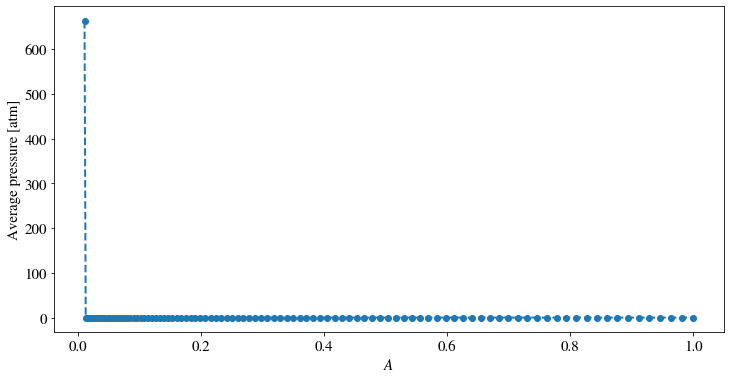

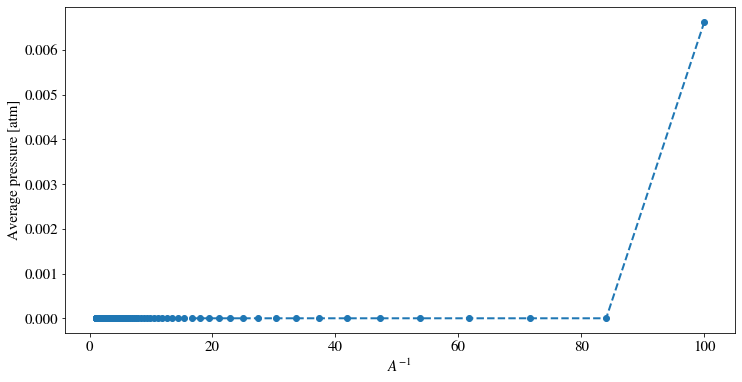

In [79]:
analytic_pressure_list = 300*N/(lengths**(2))
plt.plot(lengths**2, np.array(avg_pressure_list), "--o")
# plt.plot(lengths**2, analytic_pressure_list, "o")
plt.xlabel(r"$A$")
plt.ylabel("Average pressure [atm]")
plt.show()

plt.plot(lengths**(-2), np.array(avg_pressure_list)/1e5, "--o")
plt.xlabel(r"$A^{-1}$")
plt.ylabel("Average pressure [atm]")
plt.show()

The plots above shows the pressure plotted along with the area, and the inverse of the area. The plots seem to indicate that there is an inverse relationship between the pressure and the area, as expected from the ideal gas law. 